<a href="https://colab.research.google.com/github/isadays/QAOA_quantum/blob/main/QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit && pip install pylatexenc --upgrade && pip install matplotlib --upgrade && pip install qiskit-ibm-runtime && pip install qiskit-aer



In [ ]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [ ]:
from qiskit.quantum_info import SparsePauliOp

def build_max_cut_pauli(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_pauli= build_max_cut_pauli(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_pauli)
print("Cost Function Hamiltonian:", cost_hamiltonian)

In [24]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()
circuit.draw('text')

┌────────────────────────────┐ ░ ┌─┐            
   q_0: ┤0                           ├─░─┤M├────────────
        │                            │ ░ └╥┘┌─┐         
   q_1: ┤1                           ├─░──╫─┤M├─────────
        │                            │ ░  ║ └╥┘┌─┐      
   q_2: ┤2 QAOA(γ[0],β[0],γ[1],β[1]) ├─░──╫──╫─┤M├──────
        │                            │ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤3                           ├─░──╫──╫──╫─┤M├───
        │                            │ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ┤4                           ├─░──╫──╫──╫──╫─┤M├
        └────────────────────────────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/══════════════════════════════════╩══╩══╩══╩══╩═
                                          0  1  2  3  4

In [25]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [34]:
from qiskit_aer import Aer
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = Aer.get_backend('aer_simulator')

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('text', fold=False, idle_wires=False)



┌───┐                                                            »
   q_0: ┤ H ├─■──────────────■─────────────────────────────■─────────────»
        ├───┤ │ZZ(2.0*γ[0])  │                             │             »
   q_1: ┤ H ├─■──────────────┼──────────────■──────────────┼─────────────»
        ├───┤                │ZZ(2.0*γ[0])  │ZZ(2.0*γ[0])  │             »
   q_2: ┤ H ├────────────────■──────────────■──────────────┼─────────────»
        ├───┤                                              │             »
   q_3: ┤ H ├──────────────────────────────────────────────┼─────────────»
        ├───┤                                              │ZZ(2.0*γ[0]) »
   q_4: ┤ H ├──────────────────────────────────────────────■─────────────»
        └───┘                                                            »
meas: 5/═════════════════════════════════════════════════════════════════»
                                                                         »
«        ┌──────────────┐                                               »
«   q_0: ┤ Rx(2.0*β[0]) ├─■───────────────■─────────────────────────────»
«        ├──────────────┤ │ZZ(2.0*γ[1])   │                             »
«   q_1: ┤ Rx(2.0*β[0]) ├─■───────────────┼───────────────■─────────────»
«        └──────────────┘┌──────────────┐ │ZZ(2.0*γ[1])   │ZZ(2.0*γ[1]) »
«   q_2: ─■──────────────┤ Rx(2.0*β[0]) ├─■───────────────■─────────────»
«         │ZZ(2.0*γ[0])  └──────────────┘┌──────────────┐               »
«   q_3: ─■───────────────■──────────────┤ Rx(2.0*β[0]) ├───────────────»
«                         │ZZ(2.0*γ[0])  ├──────────────┤               »
«   q_4: ─────────────────■──────────────┤ Rx(2.0*β[0]) ├───────────────»
«                                        └──────────────┘               »
«meas: 5/═══════════════════════════════════════════════════════════════»
«                                                                       »
«                       ┌──────────────┐                                 ░ ┌─┐»
«   q_0: ─■─────────────┤ Rx(2.0*β[1]) ├─────────────────────────────────░─┤M├»
«         │             ├──────────────┤                                 ░ └╥┘»
«   q_1: ─┼─────────────┤ Rx(2.0*β[1]) ├─────────────────────────────────░──╫─»
«         │             └──────────────┘┌──────────────┐                 ░  ║ »
«   q_2: ─┼──────────────■──────────────┤ Rx(2.0*β[1]) ├─────────────────░──╫─»
«         │              │ZZ(2.0*γ[1])  └──────────────┘┌──────────────┐ ░  ║ »
«   q_3: ─┼──────────────■───────────────■──────────────┤ Rx(2.0*β[1]) ├─░──╫─»
«         │ZZ(2.0*γ[1])                  │ZZ(2.0*γ[1])  ├──────────────┤ ░  ║ »
«   q_4: ─■──────────────────────────────■──────────────┤ Rx(2.0*β[1]) ├─░──╫─»
«                                                       └──────────────┘ ░  ║ »
«meas: 5/═══════════════════════════════════════════════════════════════════╩═»
«                                                                           0 »
«                    
«   q_0: ────────────
«        ┌─┐         
«   q_1: ┤M├─────────
«        └╥┘┌─┐      
«   q_2: ─╫─┤M├──────
«         ║ └╥┘┌─┐   
«   q_3: ─╫──╫─┤M├───
«         ║  ║ └╥┘┌─┐
«   q_4: ─╫──╫──╫─┤M├
«         ║  ║  ║ └╥┘
«meas: 5/═╩══╩══╩══╩═
«         1  2  3  4

In [35]:
import numpy as np
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [36]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [37]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect 

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.878121878121878
       x: [ 2.602e+00  1.243e+00  1.928e+00  1.687e+00]
    nfev: 29
   maxcv: 0.0


/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


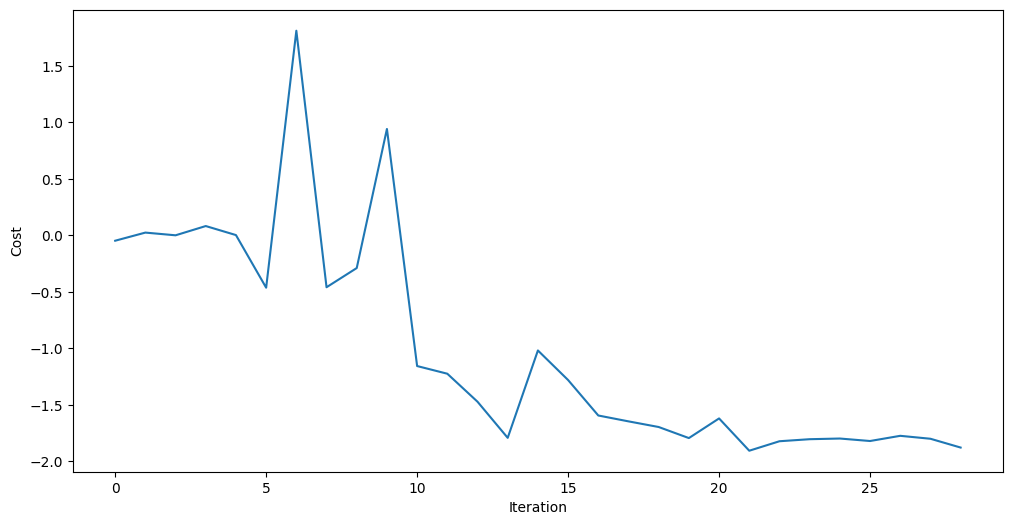

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [40]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('text', fold=False, idle_wires=False)

┌───┐                                                    ┌────────────┐»
   q_0: ┤ H ├─■────────────■─────────────────────────■───────────┤ Rx(5.2035) ├»
        ├───┤ │ZZ(3.8556)  │                         │           ├────────────┤»
   q_1: ┤ H ├─■────────────┼────────────■────────────┼───────────┤ Rx(5.2035) ├»
        ├───┤              │ZZ(3.8556)  │ZZ(3.8556)  │           └────────────┘»
   q_2: ┤ H ├──────────────■────────────■────────────┼────────────■────────────»
        ├───┤                                        │            │ZZ(3.8556)  »
   q_3: ┤ H ├────────────────────────────────────────┼────────────■────────────»
        ├───┤                                        │ZZ(3.8556)               »
   q_4: ┤ H ├────────────────────────────────────────■─────────────────────────»
        └───┘                                                                  »
meas: 5/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                              ┌────────────┐»
«   q_0: ─■─────────────■──────────────────────────■───────────┤ Rx(2.4856) ├»
«         │ZZ(3.3732)   │                          │           ├────────────┤»
«   q_1: ─■─────────────┼─────────────■────────────┼───────────┤ Rx(2.4856) ├»
«        ┌────────────┐ │ZZ(3.3732)   │ZZ(3.3732)  │           └────────────┘»
«   q_2: ┤ Rx(5.2035) ├─■─────────────■────────────┼────────────■────────────»
«        └────────────┘┌────────────┐              │            │ZZ(3.3732)  »
«   q_3: ─■────────────┤ Rx(5.2035) ├──────────────┼────────────■────────────»
«         │ZZ(3.8556)  ├────────────┤              │ZZ(3.3732)               »
«   q_4: ─■────────────┤ Rx(5.2035) ├──────────────■─────────────────────────»
«                      └────────────┘                                        »
«meas: 5/════════════════════════════════════════════════════════════════════»
«                                                                            »
«                                     ░ ┌─┐            
«   q_0: ─────────────────────────────░─┤M├────────────
«                                     ░ └╥┘┌─┐         
«   q_1: ─────────────────────────────░──╫─┤M├─────────
«        ┌────────────┐               ░  ║ └╥┘┌─┐      
«   q_2: ┤ Rx(2.4856) ├───────────────░──╫──╫─┤M├──────
«        └────────────┘┌────────────┐ ░  ║  ║ └╥┘┌─┐   
«   q_3: ─■────────────┤ Rx(2.4856) ├─░──╫──╫──╫─┤M├───
«         │ZZ(3.3732)  ├────────────┤ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ─■────────────┤ Rx(2.4856) ├─░──╫──╫──╫──╫─┤M├
«                      └────────────┘ ░  ║  ║  ║  ║ └╥┘
«meas: 5/════════════════════════════════╩══╩══╩══╩══╩═
«                                        0  1  2  3  4

In [41]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{26: 0.2139, 20: 0.0459, 5: 0.2122, 6: 0.0108, 2: 0.0386, 9: 0.0438, 11: 0.0481, 18: 0.0526, 10: 0.055, 13: 0.0517, 22: 0.0463, 17: 0.0109, 21: 0.0501, 28: 0.0108, 29: 0.0377, 19: 0.0121, 12: 0.0134, 3: 0.0106, 25: 0.0099, 30: 0.0015, 1: 0.0012, 4: 0.0013, 23: 0.0028, 27: 0.0027, 24: 0.0009, 14: 0.0091, 8: 0.0015, 16: 0.0018, 15: 0.0019, 7: 0.0009}


/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [42]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 1, 1]


<ipython-input-43-8d96f5cf5f81>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


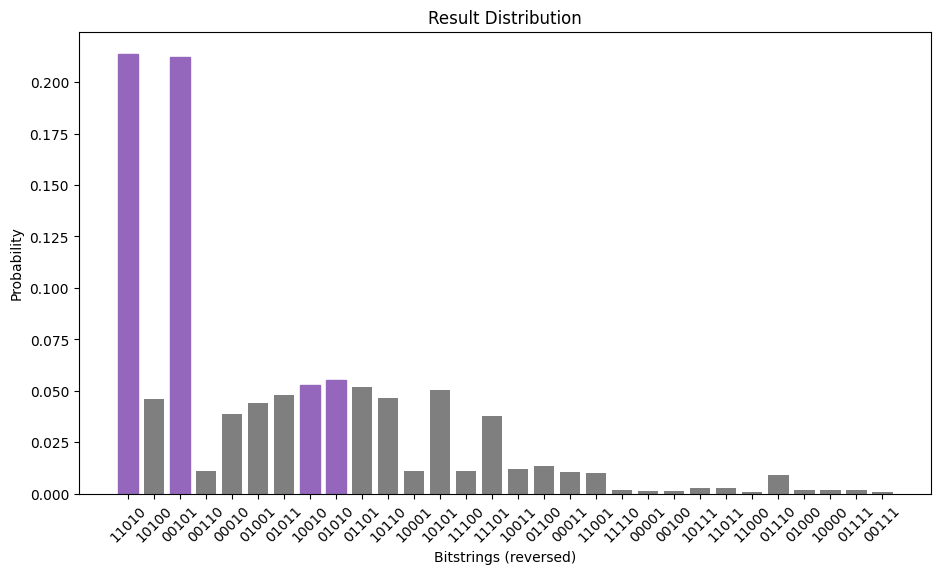

In [43]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

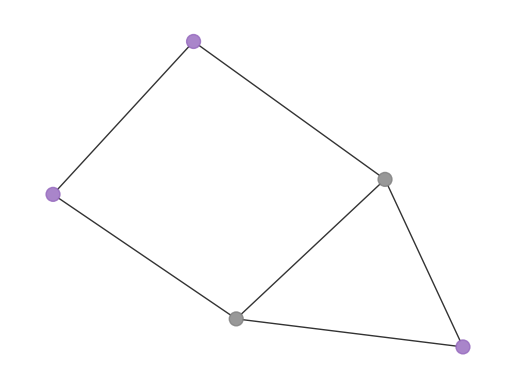

In [44]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [45]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 4
